## Preparation

### Imports

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torchvision.utils as vutils
import random
import os
import shutil

### Set seed

In [2]:
manual_seed = 86347917
random.seed(manual_seed)
torch.manual_seed(manual_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(manual_seed)

## Data loaders

### SVHN Dataset

In [3]:
class SvhnDataset(Dataset):
    def __init__(self, image_size, split):
        self.split = split
        self.use_gpu = True if torch.cuda.is_available() else False

        self.svhn_dataset = self._create_dataset(image_size, split)
        self.label_mask = self._create_label_mask()

    def _create_dataset(self, image_size, split):
        normalize = transforms.Normalize(
            mean=[0.5, 0.5, 0.5],
            std=[0.5, 0.5, 0.5])
        transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            normalize])
        return datasets.SVHN(root='./svhn', download=True, transform=transform, split=split)

    def _is_train_dataset(self):
        return True if self.split == 'train' else False

    def _create_label_mask(self):
        if self._is_train_dataset():
            label_mask = np.zeros(len(self.svhn_dataset))
            label_mask[0:1000] = 1
            np.random.shuffle(label_mask)
            label_mask = torch.LongTensor(label_mask)
            return label_mask
        return None

    def __len__(self):
        return len(self.svhn_dataset)

    def __getitem__(self, idx):
        data, label = self.svhn_dataset.__getitem__(idx)
        if self._is_train_dataset():
            return data, label, self.label_mask[idx]
        return data, label

### Get data loaders

In [4]:
def get_loader(image_size, batch_size):
    num_workers = 1

    svhn_train = SvhnDataset(image_size=image_size, split='train')
    svhn_test = SvhnDataset(image_size=image_size, split='test')

    svhn_loader_train = DataLoader(
        dataset=svhn_train,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers
    )

    svhn_loader_test = DataLoader(
        dataset=svhn_test,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers
    )

    return svhn_loader_train, svhn_loader_test

In [5]:
svhn_loader_train, _ = get_loader(image_size=32, batch_size=36)
image_iter = iter(svhn_loader_train)
images, _, _ = image_iter.next()

Using downloaded and verified file: ./svhn/train_32x32.mat
Using downloaded and verified file: ./svhn/test_32x32.mat


Process Process-1:
Traceback (most recent call last):
  File "/home/vetal/anaconda3/envs/aind2/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/home/vetal/anaconda3/envs/aind2/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/vetal/anaconda3/envs/aind2/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 36, in _worker_loop
    r = index_queue.get()
  File "/home/vetal/anaconda3/envs/aind2/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/home/vetal/anaconda3/envs/aind2/lib/python3.5/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/home/vetal/anaconda3/envs/aind2/lib/python3.5/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/home/vetal/anaconda3/envs/aind2/lib/python3.5/multiprocessing/connection.py", line 379, in _re

In [6]:
def view_images(images):
    assert(len(images) >= 36)
    fig, axes = plt.subplots(6, 6, sharex=True, sharey=True, figsize=(5,5))
    for idx, ax in enumerate(axes.flatten()):
        img = images[idx].numpy()
        img = img.transpose(1, 2, 0)
        img = ((img - img.min())*255 / (img.max() - img.min())).astype(np.uint8)
        ax.imshow(img, aspect='equal')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
    plt.subplots_adjust(wspace=0, hspace=0)

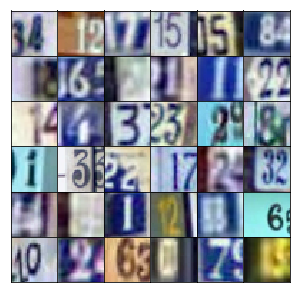

In [7]:
view_images(images)

## Model

### GAN logits

In [8]:
class _ganLogits(nn.Module):
    def __init__(self, num_classes):
        super(_ganLogits, self).__init__()
        self.num_classes = num_classes
    
    def forward(self, class_logits):
        real_class_logits, fake_class_logits = torch.split(class_logits, self.num_classes, dim=1)
        fake_class_logits = torch.squeeze(fake_class_logits)
        
        max_val, _ = torch.max(real_class_logits, 1, keepdim=True)
        stable_class_logits = real_class_logits - max_val
        max_val = torch.squeeze(max_val)
        gan_logits = torch.log(torch.sum(torch.exp(stable_class_logits), 1)) + max_val - fake_class_logits
        
        return gan_logits

### Generator

In [9]:
class _netG(nn.Module):
    def __init__(self, nz, ngf, alpha, nc, use_gpu):
        super(_netG, self).__init__()
        self.use_gpu = use_gpu
        
        self.main = nn.Sequential(
            # noise is going into a convolution
            nn.ConvTranspose2d(nz, ngf * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.LeakyReLU(alpha),
            # (ngf * 4) x 4 x 4
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.LeakyReLU(alpha),
            # (ngf * 2) x 8 x 8
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.LeakyReLU(alpha),
            # (ngf) x 16 x 16
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # (nc) x 32 x 32
        )

    def forward(self, inputs):
        if isinstance(inputs.data, torch.cuda.FloatTensor) and self.use_gpu:
            out = nn.parallel.data_parallel(self.main, inputs, range(1))
        else:
            out = self.main(inputs)
        return out

### Discriminator

In [10]:
class _netD(nn.Module):
    def __init__(self, ndf, alpha, nc, drop_rate, num_classes, use_gpu):
        super(_netD, self).__init__()
        self.use_gpu = use_gpu
        
        self.main = nn.Sequential(
            nn.Dropout2d(drop_rate/2.5),
            
            # input is (number_channels) x 32 x 32
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(alpha),
            nn.Dropout2d(drop_rate),
            # (ndf) x 16 x 16
            nn.Conv2d(ndf, ndf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf),
            nn.LeakyReLU(alpha),
            # (ndf) x 8 x 8
            nn.Conv2d(ndf, ndf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf),
            nn.LeakyReLU(alpha),
            nn.Dropout2d(drop_rate),
            # (ndf) x 4 x 4
            nn.Conv2d(ndf, ndf * 2, 3, 1, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(alpha),
            # (ndf * 2) x 4 x 4
            nn.Conv2d(ndf * 2, ndf * 2, 3, 1, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(alpha),
            # (ndf * 2) x 4 x 4
            nn.Conv2d(ndf * 2, ndf * 2, 3, 1, 0, bias=False),
            nn.LeakyReLU(alpha),
            # (ndf * 2) x 2 x 2
        )
        
        self.features = nn.AvgPool2d(kernel_size=2)

        self.class_logits = nn.Linear(
            in_features=(ndf * 2) * 1 * 1,
            out_features=num_classes + 1)
        
        self.gan_logits = _ganLogits(num_classes)
        
        self.softmax = nn.Softmax(dim=0)

    def forward(self, inputs):
        if isinstance(inputs.data, torch.cuda.FloatTensor) and self.use_gpu:
            out = nn.parallel.data_parallel(self.main, inputs, range(1))
        else:
            out = self.main(inputs)

        features = self.features(out)
        features = features.squeeze()

        class_logits = self.class_logits(features)

        gan_logits = self.gan_logits(class_logits)
        
        out = self.softmax(class_logits)

        return out, class_logits, gan_logits, features

### Settings

In [11]:
class Settings:
    def __init__(self):
        self.image_size = 32
        self.batch_size = 128
        self.epochs = 80
        self.nz = 100
        self.nc = 3
        self.alpha = .2
        self.drop_rate = .5
        self.ngf = 32
        self.ndf = 64
        self.learning_rate = .0002
        self.beta1 = .5
        self.out_dir = './train_out'
        self.best_netG_filename = '{}/netG_best.pth'.format(self.out_dir)
        self.best_netD_filename = '{}/netD_best.pth'.format(self.out_dir)

## Solver

In [12]:
import torch
import torch.nn as nn
from torch import optim
from torch.autograd import Variable
import numpy as np
import os

class Solver:
    def __init__(self, svhn_loader_train, svhn_loader_test, settings):
        self.settings = settings
        self.use_gpu = True if torch.cuda.is_available() else False
        self.num_classes = 10
        self.svhn_loader_train = svhn_loader_train
        self.svhn_loader_test = svhn_loader_test
        
        self.netG, self.netD = self._build_model()
        self.g_optimizer, self.d_optimizer = self._create_optimizers()
        # , self.g_lr_scheduler, self.d_lr_scheduler 

    def _build_model(self):
        netG = _netG(
            self.settings.nz, self.settings.ngf, self.settings.alpha,
            self.settings.nc, self.use_gpu)
        # netG.apply(self._weights_init)
        print(netG)
        
        netD = _netD(
            self.settings.ndf, self.settings.alpha, self.settings.nc,
            self.settings.drop_rate, self.num_classes, self.use_gpu)
        # netD.apply(self._weights_init)
        print(netD)
        
        if self.use_gpu:
            netG = netG.cuda()
            netD = netD.cuda()

        return netG, netD

    def _weights_init(self, module):
        classname = module.__class__.__name__
        if classname.find('Conv') != -1:
            module.weight.data.normal_(0.0, 0.02)
        elif classname.find('BatchNorm') != -1:
            module.weight.data.normal_(1.0, 0.02)
            module.bias.data.fill_(0)

    def _create_optimizers(self):
        g_params = list(self.netG.parameters())
        d_params = list(self.netD.parameters())

        g_optimizer = optim.Adam(g_params, self.settings.learning_rate, betas=(self.settings.beta1, 0.999))
        d_optimizer = optim.Adam(d_params, self.settings.learning_rate, betas=(self.settings.beta1, 0.999))
        # g_lr_scheduler = optim.lr_scheduler.StepLR(g_optimizer, step_size=1, gamma=0.9)
        # d_lr_scheduler = optim.lr_scheduler.StepLR(d_optimizer, step_size=1, gamma=0.9)

        return g_optimizer, d_optimizer #, g_lr_scheduler, d_lr_scheduler

    def _to_var(self, x):
        if self.use_gpu:
            x = x.cuda()
        return Variable(x)

    def _one_hot(self, x):
        label_numpy = x.data.cpu().numpy()
        label_onehot = np.zeros((label_numpy.shape[0], self.num_classes + 1))
        label_onehot[np.arange(label_numpy.shape[0]), label_numpy] = 1
        label_onehot = self._to_var(torch.FloatTensor(label_onehot))
        return label_onehot
    
    def _reset_grad(self):
        self.g_optimizer.zero_grad()
        self.d_optimizer.zero_grad()

    def load_model(self, netG_filename, netD_filename):
        self.netG.load_state_dict(torch.load(netG_filename))
        self.netD.load_state_dict(torch.load(netD_filename))
        
    def test(self, epoch_num, epochs):
        correct = 0
        num_samples = 0
        self.netD.eval()
        
        for i, data in enumerate(self.svhn_loader_test):
            svhn_data, svhn_labels = data
            svhn_data = self._to_var(svhn_data)
            svhn_labels = self._to_var(svhn_labels).long().squeeze()

            d_out, _, _, _ = self.netD(svhn_data)
            _, pred_idx = torch.max(d_out.data, 1)
            eq = torch.eq(svhn_labels.data, pred_idx)
            correct += torch.sum(eq.float())
            num_samples += len(svhn_labels)
            
            if i % 50 == 0:
                print('Test:\tepoch {}/{}\tsamples {}/{}'.format(
                    epoch_num, epochs, i + 1, len(self.svhn_loader_test)))

        accuracy = correct/max(1.0, 1.0 * num_samples)
        print('Test:\tepoch {}/{}\taccuracy {}'.format(epoch_num, epochs, accuracy))
        
    def train(self):
        if not os.path.exists(self.settings.out_dir):
            os.makedirs(self.settings.out_dir)
        
        d_gan_criterion = nn.BCEWithLogitsLoss()
        d_gan_class_criterion = nn.BCEWithLogitsLoss()
        
        noise = torch.FloatTensor(self.settings.batch_size, self.settings.nz, 1, 1)
        
        fixed_noise = torch.FloatTensor(self.settings.batch_size, self.settings.nz, 1, 1).normal_(0, 1)
        fixed_noise = self._to_var(fixed_noise)
        
        d_gan_labels_real = torch.LongTensor(self.settings.batch_size)
        d_gan_labels_fake = torch.LongTensor(self.settings.batch_size)
        
        best_accuracy = 0.0

        for epoch in range(1, self.settings.epochs + 1):
            masked_correct = 0
            num_samples = 0
            
            self.netD.train()
            self.netG.train()
            for i, data in enumerate(self.svhn_loader_train):
                svhn_data, svhn_labels, label_mask = data
                svhn_data = self._to_var(svhn_data)
                svhn_labels = self._to_var(svhn_labels).long().squeeze()
                label_mask = self._to_var(label_mask).float().squeeze()

                # -------------- train netD --------------

                # self._reset_grad()
                self.netD.zero_grad()

                # train with real images
                # d_out == softmax(d_class_logits)
                d_out, d_class_logits_on_data, d_gan_logits_real, d_sample_features = self.netD(svhn_data)
                d_gan_labels_real.resize_as_(svhn_labels.data.cpu()).fill_(1)
                d_gan_labels_real_var = self._to_var(d_gan_labels_real).float()
                d_gan_loss_real = d_gan_criterion(
                    d_gan_logits_real,
                    d_gan_labels_real_var)
                
                # train with fake images
                noise.resize_(svhn_labels.data.shape[0], self.settings.nz, 1, 1).normal_(0, 1)
                noise_var = self._to_var(noise)
                fake = self.netG(noise_var)

                # call detach() to avoid backprop for netG here
                _, _, d_gan_logits_fake, _ = self.netD(fake.detach())
                d_gan_labels_fake.resize_(svhn_labels.data.shape[0]).fill_(0)
                d_gan_labels_fake_var = self._to_var(d_gan_labels_fake).float()
                d_gan_loss_fake = d_gan_criterion(
                    d_gan_logits_fake,
                    d_gan_labels_fake_var)

                d_gan_loss = d_gan_loss_real + d_gan_loss_fake

                # d_out == softmax(d_class_logits)
                # see https://stackoverflow.com/questions/34240703/whats-the-difference-between-softmax-and-softmax-cross-entropy-with-logits/39499486#39499486
                svhn_labels_one_hot = self._one_hot(svhn_labels)
                d_class_loss_entropy = -torch.sum(svhn_labels_one_hot * torch.log(d_out), dim=1)
                
                d_class_loss_entropy = d_class_loss_entropy.squeeze()
                delim = torch.max(torch.Tensor([1.0, torch.sum(label_mask.data)]))
                d_class_loss = torch.sum(label_mask * d_class_loss_entropy) / delim
                # numpy_labels = svhn_labels.data.cpu().numpy()
                # delim = torch.Tensor(numpy_labels.shape[0])
                # d_class_loss = torch.sum(d_class_loss_entropy) / delim # DO THIS FOR QUICK TEST ONLY!!!
                
                d_loss = d_gan_loss + d_class_loss
                
                d_loss.backward(retain_graph=True)
                self.d_optimizer.step()

                # -------------- update netG --------------
                
                # self._reset_grad()
                self.netG.zero_grad()

                # call netD again to do backprop for netG here
                _, _, _, d_data_features = self.netD(fake)
                
                # Here we set `g_loss` to the "feature matching" loss invented by Tim Salimans at OpenAI.
                # This loss consists of minimizing the absolute difference between the expected features
                # on the data and the expected features on the generated samples.
                # This loss works better for semi-supervised learning than the tradition GAN losses.
                data_features_mean = torch.mean(d_data_features, dim=0).squeeze()
                sample_features_mean = torch.mean(d_sample_features, dim=0).squeeze()
                
                g_loss = torch.mean(torch.abs(data_features_mean - sample_features_mean))

                g_loss.backward()
                self.g_optimizer.step()

                _, pred_class = torch.max(d_class_logits_on_data, 1)
                eq = torch.eq(svhn_labels, pred_class)
                correct = torch.sum(eq.float())
                masked_correct += torch.sum(label_mask * eq.float())
                # masked_correct += correct
                num_samples += torch.sum(label_mask)
                # num_samples += numpy_labels.shape[0]
                
                if i % 200 == 0:
                    print('Training:\tepoch {}/{}\tdiscr. gan loss {}\tdiscr. class loss {}\tgen loss {}\tsamples {}/{}'.
                        format(epoch, self.settings.epochs, d_gan_loss.data[0], d_class_loss.data[0], g_loss.data[0], 
                               i + 1, len(self.svhn_loader_train)))
                    real_cpu, _, _ = data
                    vutils.save_image(real_cpu,
                            '%s/real_samples.png' % self.settings.out_dir,
                            normalize=True)
                    fake = self.netG(fixed_noise)
                    vutils.save_image(fake.data,
                            '{}/fake_samples_epoch_{:03d}.png'.format(self.settings.out_dir, epoch),
                            normalize=True)
                    
            accuracy = masked_correct.data[0]/max(1.0, num_samples.data[0])
            print('Training:\tepoch {}/{}\taccuracy {}'.format(epoch, self.settings.epochs, accuracy))

            self.test(epoch, self.settings.epochs)

            # do checkpointing
            netG_filename = '{}/netG_epoch_{}.pth'.format(self.settings.out_dir, epoch)
            netD_filename = '{}/netD_epoch_{}.pth'.format(self.settings.out_dir, epoch)
            torch.save(self.netG.state_dict(), netG_filename)
            torch.save(self.netD.state_dict(), netD_filename)
            
            # decay learning rate
            # self.g_lr_scheduler.step()
            # self.d_lr_scheduler.step()
            
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                shutil.copyfile(netG_filename, self.settings.best_netG_filename)
                shutil.copyfile(netD_filename, self.settings.best_netD_filename)

## Main

In [13]:
settings = Settings()
svhn_loader_train, svhn_loader_test = get_loader(settings.image_size, settings.batch_size)
solver = Solver(svhn_loader_train, svhn_loader_test, settings)

Using downloaded and verified file: ./svhn/train_32x32.mat
Using downloaded and verified file: ./svhn/test_32x32.mat
_netG(
  (main): Sequential(
    (0): ConvTranspose2d (100, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (2): LeakyReLU(0.2)
    (3): ConvTranspose2d (128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (5): LeakyReLU(0.2)
    (6): ConvTranspose2d (64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
    (8): LeakyReLU(0.2)
    (9): ConvTranspose2d (32, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)
_netD(
  (main): Sequential(
    (0): Dropout2d(p=0.2)
    (1): Conv2d (3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (2): LeakyReLU(0.2)
    (3): Dropout2d(p=0.5)
   

In [14]:
if os.path.exists(settings.best_netG_filename) and os.path.exists(settings.best_netD_filename):
    solver.load_model(settings.best_netG_filename, settings.best_netD_filename)
    solver.test(1, 1)
else:
    solver.train()

Training:	epoch 1/80	discr. gan loss 2.4501492977142334	discr. class loss 4.818782329559326	gen loss 0.019136808812618256	samples 1/573
Training:	epoch 1/80	discr. gan loss 1.4359393119812012	discr. class loss 4.6805830001831055	gen loss 0.016958529129624367	samples 201/573
Training:	epoch 1/80	discr. gan loss 1.3593182563781738	discr. class loss 4.69292688369751	gen loss 0.030257899314165115	samples 401/573
Training:	epoch 1/80	accuracy 0.002
Test:	epoch 1/80	samples 1/204
Test:	epoch 1/80	samples 51/204
Test:	epoch 1/80	samples 101/204
Test:	epoch 1/80	samples 151/204
Test:	epoch 1/80	samples 201/204
Test:	epoch 1/80	accuracy 0.08850645359557467
Training:	epoch 2/80	discr. gan loss 1.3303248882293701	discr. class loss 5.320976257324219	gen loss 0.012292692437767982	samples 1/573
Training:	epoch 2/80	discr. gan loss 1.5282812118530273	discr. class loss 4.718095779418945	gen loss 0.013000484555959702	samples 201/573
Training:	epoch 2/80	discr. gan loss 1.4158188104629517	discr. class l

Test:	epoch 13/80	samples 1/204
Test:	epoch 13/80	samples 51/204
Test:	epoch 13/80	samples 101/204
Test:	epoch 13/80	samples 151/204
Test:	epoch 13/80	samples 201/204
Test:	epoch 13/80	accuracy 0.28326674861708667
Training:	epoch 14/80	discr. gan loss 1.2742868661880493	discr. class loss 4.633314609527588	gen loss 0.033444929867982864	samples 1/573
Training:	epoch 14/80	discr. gan loss 1.2236205339431763	discr. class loss 3.993698835372925	gen loss 0.05020196735858917	samples 201/573
Training:	epoch 14/80	discr. gan loss 1.1039023399353027	discr. class loss 4.185575485229492	gen loss 0.042192015796899796	samples 401/573
Training:	epoch 14/80	accuracy 0.04
Test:	epoch 14/80	samples 1/204
Test:	epoch 14/80	samples 51/204
Test:	epoch 14/80	samples 101/204
Test:	epoch 14/80	samples 151/204
Test:	epoch 14/80	samples 201/204
Test:	epoch 14/80	accuracy 0.33428088506453596
Training:	epoch 15/80	discr. gan loss 1.1683881282806396	discr. class loss 0.0	gen loss 0.032314982265233994	samples 1/573

Traceback (most recent call last):
Process Process-36:
  File "/home/vetal/anaconda3/envs/aind2/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/home/vetal/anaconda3/envs/aind2/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/vetal/anaconda3/envs/aind2/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 36, in _worker_loop
    r = index_queue.get()
  File "/home/vetal/anaconda3/envs/aind2/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/home/vetal/anaconda3/envs/aind2/lib/python3.5/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/home/vetal/anaconda3/envs/aind2/lib/python3.5/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/home/vetal/anaconda3/envs/aind2/lib/python3.5/multiprocessing/connection.py", line 379, in _r

KeyboardInterrupt: 